In [11]:
import os
import numpy as np
from matplotlib import pyplot as pl

import scipy.io.wavfile as wav
from python_speech_features import mfcc

import mlp_backprop_momentum as mlp
import k_fold_cross_validation as cv

%matplotlib inline

In [145]:
PATH = './vowels/'

SAMPLE_RATE = 24000

N_INITS = 5
N_INPUT_NEURONS = 13
EPOCHS = 100
K = 5
LEARNING_RATE = 0.001
MOMENTUM = 0.5

## Load data, pre-process it and label it

We load every wav file and process them using Mel-Frequency Cepstral Coefficients. We then aggregate the coefficients of each window using an average.

In [123]:
# Compute MFCC for each signal and aggregate windows using the average
def compute_mfcc_average(data):
    return np.average(mfcc(data, samplerate=SAMPLE_RATE, nfft=1024), axis=0)

In [124]:
files = [file for file in os.listdir(PATH) if file.endswith(".wav")]
signals = []

for file in files:
    data = compute_mfcc_average(wav.read(os.path.join(PATH, file))[1])
    signals.append([file[:-4], data])

In [129]:
# Add labels to the list
for signal in signals:
    name = signal[0]
    
    # Natural voice (1) or synthetic (-1)
    signal.append(1 if name[0] == 'n' else -1)
    
    # Kid voice (0), adult female (1) or adult male (-1)
    if name[1] == 'k':
        signal.append(0)
    else:
        signal.append(1 if name[2] == 'f' else -1)

In [130]:
# Keep only natural voices
natural_mf = [s for s in signals if s[2] == 1 and s[3] != 0]
print(len(natural_mf))

72


In [136]:
# Extract a list of labels
ceps = [s[1] for s in natural_mf]
labels = [s[3] for s in natural_mf]

dataset = np.array([np.append(s, l) for s, l in zip(ceps, labels)])

## Create neural network

In [137]:
MSE_train = np.zeros((EPOCHS, N_INITS))
MSE_test = np.zeros((EPOCHS, N_INITS))

nn = mlp.MLP([N_INPUT_NEURONS, 1, 1], 'tanh')

for i in np.arange(N_INITS):
    nn.init_weights()
    MSE_train[:, i], MSE_test[:, i] = cv.k_fold_cross_validation_per_epoch(nn, dataset, k=K,
                                                                           learning_rate=LEARNING_RATE,
                                                                           momentum=MOMENTUM,
                                                                           epochs=EPOCHS)
print(N_INITS * K, "tests done")

25 tests done


## Validating the results

Confusion matrix, F-score, cross-validation results...

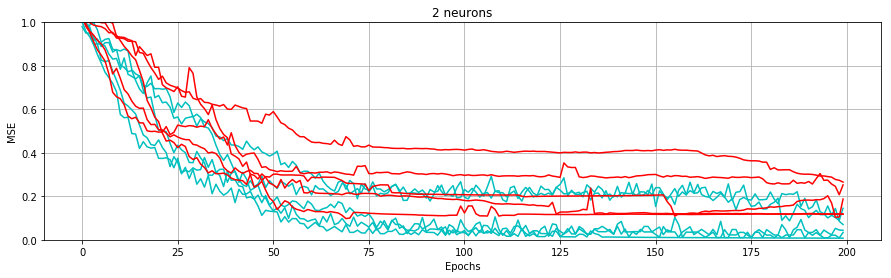

In [138]:
pl.figure(figsize=(15, 4))
pl.plot(MSE_train, c='c')
pl.plot(MSE_test, c='r')
pl.ylim(0, 1)
pl.xlabel("Epochs")
pl.ylabel("MSE")
pl.title("{} neurons".format(N_HIDDEN_NEURONS))
pl.grid()

---

---

## Copying the given code to test

### Exploring the number of epochs

In [151]:
N_NEURONS = [2, 4, 8]

MSE = np.zeros((len(N_NEURONS), N_INITS, EPOCHS))

for i_h, h in enumerate(N_NEURONS):                                     # looping over the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([N_INPUT_NEURONS,h,1], 'tanh')
    for i in np.arange(N_INITS):                                        # looping over the initializations
        nn.init_weights()

        MSE[i_h, i, :] = nn.fit((dataset[:,0:13], dataset[:,13:14]),
                                learning_rate=LEARNING_RATE,
                                momentum=MOMENTUM,
                                epochs=EPOCHS)

Testing 2 neurons...
Testing 4 neurons...
Testing 8 neurons...


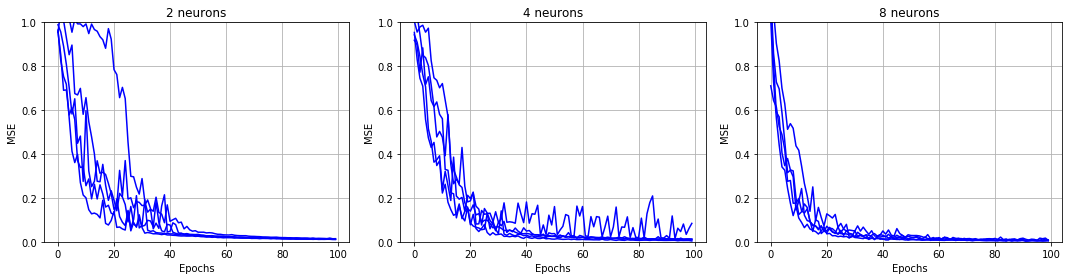

In [152]:
pl.figure(figsize=(15,4))
p_count = 0
for n in np.arange(MSE.shape[0]):
    pl.subplot(1, MSE.shape[0], n+1)
    for i in np.arange(MSE.shape[1]):
        pl.plot(MSE[n,i,:], c='b')
    pl.ylim(0,1)
    pl.xlabel('Epochs')
    pl.ylabel('MSE')
    pl.title(str(N_NEURONS[n]) + ' neurons')
    pl.grid()
pl.tight_layout()

### Exploring the number of hidden neurons

In [156]:
N_NEURONS = [2, 4, 6, 8, 10, 15, 20, 25, 30]
N_TESTS = 10

MSE_train = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))
MSE_test = np.zeros((len(N_NEURONS), EPOCHS, N_TESTS))

for i_h, h in enumerate(N_NEURONS):                                     # looping the number of hidden neurons
    print('Testing', h, 'neurons...')
    nn = mlp.MLP([N_INPUT_NEURONS,h,1], 'tanh')
    for i in np.arange(N_TESTS):                                        # looping the tests
        nn.init_weights()                                               # the network has to be reinitialized before each test
        temp1, temp2 = cv.k_fold_cross_validation_per_epoch(nn,         # notice that we do not use cv.k_fold_cross_validation
                                                            dataset,    # but cv.k_fold_cross_validation_per_epoch which
                                                            k=K,        # returns a value of error per each epoch
                                                            learning_rate=LEARNING_RATE,
                                                            momentum=MOMENTUM,
                                                            epochs=EPOCHS)
        # temp1 and temp2 are the training and test error. One value per epoch
        MSE_train[i_h, :, i] = temp1
        MSE_test[i_h, :, i] = temp2

Testing 2 neurons...
Testing 4 neurons...
Testing 6 neurons...
Testing 8 neurons...
Testing 10 neurons...
Testing 15 neurons...
Testing 20 neurons...
Testing 25 neurons...
Testing 30 neurons...


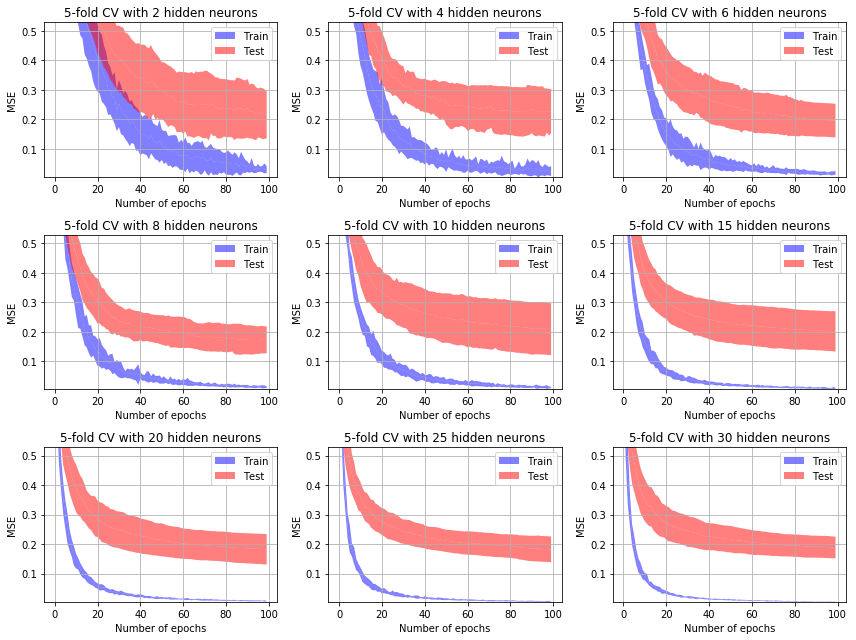

In [157]:
MSE_train_mean = np.mean(MSE_train, axis=2)
MSE_test_mean = np.mean(MSE_test, axis=2)
MSE_train_sd = np.std(MSE_train, axis=2)
MSE_test_sd = np.std(MSE_test, axis=2)

v_min = min(np.min(MSE_train_mean), np.min(MSE_test_mean))
v_max = max(np.max(MSE_train_mean), np.max(MSE_test_mean))

n_rows = int(np.ceil(len(N_NEURONS)/3.0))
pl.figure(figsize=(12,3*n_rows))
for i_n, n in enumerate(N_NEURONS):
    pl.subplot(n_rows, min(3, len(N_NEURONS)), i_n+1)
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]+MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5, label='Train')
    pl.fill_between(np.arange(EPOCHS), MSE_train_mean[i_n,:], MSE_train_mean[i_n,:]-MSE_train_sd[i_n,:], facecolor='blue', alpha=0.5)
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]+MSE_test_sd[i_n,:], facecolor='red', alpha=0.5, label='Test')
    pl.fill_between(np.arange(EPOCHS), MSE_test_mean[i_n,:], MSE_test_mean[i_n,:]-MSE_test_sd[i_n,:], facecolor='red', alpha=0.5)
    pl.ylim(0.95*v_min,0.5*v_max)
    pl.ylabel('MSE')
    pl.xlabel('Number of epochs')
    pl.title(str(K)+'-fold CV with '+str(n)+' hidden neurons')
    pl.legend()
    pl.grid()
pl.tight_layout()

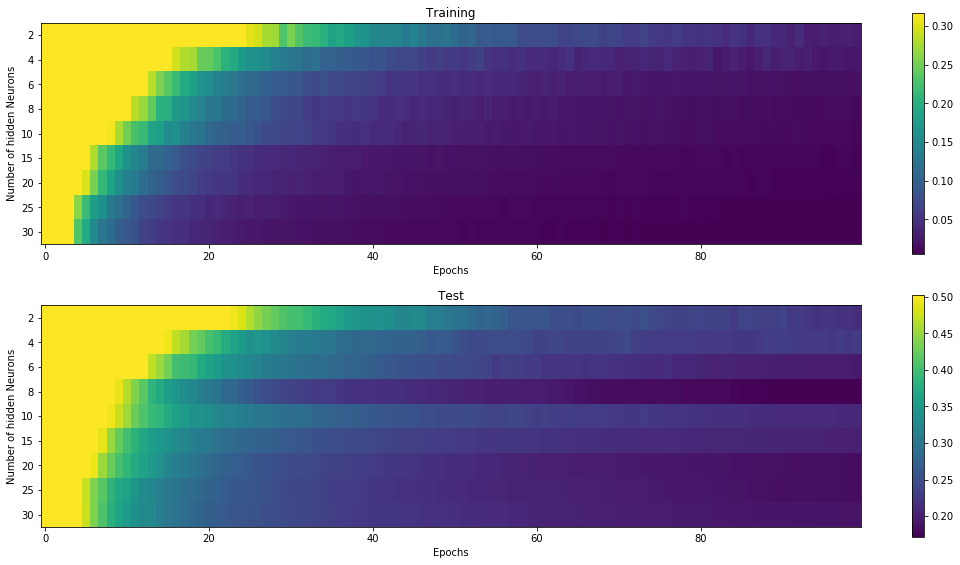

In [158]:
pl.figure(figsize=(15,8))
pl.subplot(2,1,1)
pl.imshow(MSE_train_mean, vmin=np.min(MSE_train_mean), vmax=np.percentile(MSE_train_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Training')
pl.colorbar()
pl.subplot(2,1,2)
pl.imshow(MSE_test_mean, vmin=np.min(MSE_test_mean), vmax=np.percentile(MSE_test_mean, 90), aspect=3, interpolation='nearest')
pl.yticks(np.arange(len(N_NEURONS)), N_NEURONS)
pl.xlabel('Epochs')
pl.ylabel('Number of hidden Neurons')
pl.title('Test')
pl.colorbar()
pl.tight_layout()

In [160]:
nn = mlp.MLP([N_INPUT_NEURONS,2,1], 'tanh')

MSE_train, MSE_test, conf_mat = cv.k_fold_cross_validation(nn,
                                                          dataset,
                                                          k=K,
                                                          learning_rate=LEARNING_RATE,
                                                          momentum=MOMENTUM,
                                                          epochs=75,
                                                          threshold=0.0)

print('MSE training: ', MSE_train)
print('MSE test: ', MSE_test)
print('Confusion matrix:')
print(conf_mat)

MSE training:  0.03623862238911516
MSE test:  0.3115498761832556
Confusion matrix:
[[32.  4.]
 [ 5. 31.]]
